In [1]:
import markdown
from bs4 import BeautifulSoup

text_path = './document/income_tax.txt'
markdown_path = "./document/income_tax.md"

# 마크다운 파일을 읽어옵니다
with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


In [2]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=100,
    separators=["\n\n", "\n"]
)


loader = TextLoader("./document/income_tax.txt")

docs = loader.load_and_split(text_splitter)

In [3]:
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

embeddings = OllamaEmbeddings(model="qwen2.5:14b")

vector_store = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)


In [4]:
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="qwen2.5:14b")

vector_store = Chroma(
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
    embedding_function=embeddings,
)

In [5]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

retriever = vector_store.as_retriever(search_kwargs={'k': 5})
query = '연봉 5천만원 직장인의 소득세는 얼마야?'

class AgentState(TypedDict):
    query : str
    context : List[Document]
    answer : str


graph_builder = StateGraph(AgentState)


def retrieve(state: AgentState) :
    query = state['query']
    docs = retriever.invoke(query)
    return {'context' : docs}

In [6]:
from langsmith import Client
from langchain_ollama import ChatOllama

client = Client()
prompt = client.pull_prompt("rlm/rag-prompt")

llm = ChatOllama(model="qwen2.5:14b")




def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question' : query, 'context' : context})
    return {'answer' : response}

In [7]:
from langgraph.graph import START, END

# 추가를 한번에 하는 방법
#graph_builder.add_node('retrieval', retrieve)
#graph_builder.add_node('generation', generate)
#graph_builder.add_edge(START, "retrieval")
#graph_builder.add_edge("retrieval", 'generation')
#graph_builder.add_edge('generation', END)

sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])
sequence_graph_builder.add_edge(START, "retrieve")
sequence_graph_builder.add_edge('generate', END)

graph = sequence_graph_builder.compile()

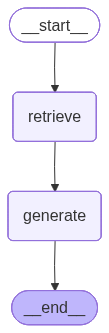

In [8]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
initial_state = {'query' : query}
graph.invoke(initial_state)

{'query': '연봉 5천만원 직장인의 소득세는 얼마야?',
 'context': [Document(id='2e0c864d-8f1b-48e9-b7ab-f62eaffa39fe', metadata={'source': './document/income_tax.txt'}, page_content='1. 취득가액에 실지거래가액에 의하여 취득시 실지거래가액을 계산하는 경우 금액으로 한다.\n가. 제96조제1호 및 제197조제3항에 따른 환산처가액에 의하여 취득 당시 실지거래가액에 의하여 취득한 자산(상속 또는 증여받은 자산을 포함하는 자산)을 포함한다)이 취득가액을 취득 당시 실지거래가액과 그 가액에 취득일부터 의제취득기한의 전기부문까지의 주요한 생산자금을 포함하여 계산한 가액\n나. 제기한 각 의의 부분에 의하여 포함한 자산 실지거래가액\n다. 별의 경우에 필요경비는 제197조제1항(제197조의 적용되는 경우로 제외한다), 제197조(제197조와의 적용이 되는 경우로 제외한다) 또는 제197조제7항(제197조의 적용되는 경우로 제외한다) 금액에 의하여 그 양도가액에 환산처가액의 합계\n소득세법\n나. 제1항제2호 및 제3호에 대한 금액의 합계액\n1. 제3조에 따라 필요경비를 계산할 때 양도자산 보유기간에 그 자산에 대한 감가상각비와 각 과세기간의 사업소득을 계산할 경우 필요경비에 산입했던 금액이 있을 때에는 이 일제한의 금액에 공동한 금액으로 취급하거나 한다. <개정 2010. 12. 27.>\n2. 삭제 <2014. 1. 1.>\n3. 취득에 따른 실지거래가액의 범위 등 필요경비의 계산할 경우 사용한 대통레선롤로 보장한다. <개정 2014. 1. 1.>\n4. 삭제 <2014. 1. 1.>\n제97조의2(양도소득의 필요경비의 계산 특례) \n① 거주자가 양도유명부 소급하여 10년 이내에 보유한 양도 자산에 대한 혼인 관계가 소멸된 경우를 포함하며, 사망으로 혼인관계가 소멸된 경우를 제한한다. 이하 이 항에 각단도 직접제한 사업소득에 정하는 제97조제1항1호에 대